In [1]:
import sys
sys.path.append("../..")
import torch
import numpy as np
import matplotlib.pyplot as plt
from data_utils      import *
from model_utils     import get_network
from tqdm import tqdm
import seaborn as sns
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# create dataloaders
channel, im_size, train_n_classes, test_n_classes, dst_train, dst_test = get_dataset(
        "CIFAR10",
        "../../data",
        zca=False
    )
assert train_n_classes == test_n_classes
train_loader = torch.utils.data.DataLoader(dst_train, batch_size=256, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(dst_test, batch_size=256, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
# store test data for faster inference (run on RTX 3090 with 24GB of VRAM)
test_label = []
test_img = []
with torch.no_grad():
    for x, y in tqdm(test_loader):
        test_label.append(y)
        test_img.append(x)
test_label = torch.hstack(test_label).to(device)
test_img = torch.vstack(test_img).to(device)
print(test_img.shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 45.11it/s]


torch.Size([10000, 3, 32, 32])


In [6]:
# generate distilled predictions
distilled_predictions = [] # the classes the model predicted
distilled_correct = [] # store whether the model makes correct predictions
distilled_acc = [] # store accuracy of model
for i in range(4):
    data = torch.load(f"../../DD_data/{i}.pt")
    synthetic_data = data["data"].to(device)
    synthetic_label = data["label"].to(device)
    distilled_model = get_network("ConvNet", 3, 10, (32,32)).to(device)
    optim = torch.optim.SGD(distilled_model.parameters(), lr=0.01, momentum=0.9)
    criterion = torch.nn.CrossEntropyLoss()
    for _ in range(300):
        distilled_model.train()
        loss = criterion(distilled_model(synthetic_data)[-1], synthetic_label)
        optim.zero_grad()
        loss.backward()
        optim.step()

    with torch.no_grad():
        distilled_model.eval()
        pred = distilled_model(test_img)[-1]
        distilled_predictions.append(torch.argmax(pred, dim=1).cpu().numpy())
        distilled_correct.append((torch.argmax(pred, dim=1) == test_label).cpu().numpy())
    distilled_acc.append(np.sum(distilled_correct[-1])/len(distilled_correct[-1]))
print(distilled_acc)

[0.589, 0.4266, 0.4596, 0.5363]


In [7]:
# fetch subset-trained-models predictions and early-stopped-models predictions
subset_results = []
for i in tqdm(range(520)):
    data = torch.load(f"../../experiment_results/agreement_models/subset_{i}.pt")
    subset_results.append((data["accuracy"], data["predictions"]))

earlystopping_results = []
for i in tqdm(range(30)):
    data = torch.load(f"../../experiment_results/agreement_models/earlystopping_{i}.pt")
    earlystopping_results.append((data["predictions"]))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  7.95it/s]


In [8]:
# extract the accuracies in the subset-trained-models
subset_correctness = {}
for test_accuracy, test_predictions in subset_results:
    acc = round(test_accuracy, 2)
    if acc not in subset_correctness:
        subset_correctness[acc] = [test_predictions]
    else:
        subset_correctness[acc].append(test_predictions)

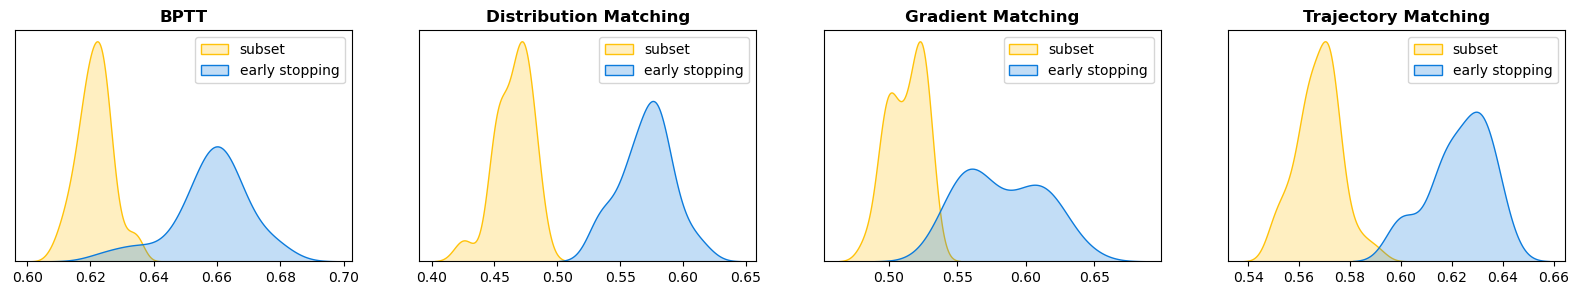

In [9]:
# genereate the results
plt.figure(figsize=(20, 3))
plt.subplots_adjust(hspace=0.3)
dataset_size = len(dst_test)
iter_earlystopping = [130, 40, 35, 90] # hand coded early stopped iteration with the closest accuracy to distilled-trained-models
names = ['BPTT', 'Distribution Matching', 'Gradient Matching', 'Trajectory Matching']
for index in range(4):
    # round accuracy to two decimal places
    new_acc =int(distilled_acc[index]*100)
    l = subset_correctness[new_acc/100.0] + subset_correctness[(new_acc+1)/100.0] 

    # calculate agreements against subset trained models
    num_agreements_subset = []
    for i in range(len(l)):
        num_agreements_subset.append(np.sum(distilled_predictions[index] == l[i]))
    num_agreements_subset = np.array(num_agreements_subset)

    # calculate agreements against early-stopped models
    num_agreements_early_stopping = []
    for i in range(len(earlystopping_results)):
        num_agreements_early_stopping.append(np.sum(distilled_predictions[index] == earlystopping_results[i][iter_earlystopping[index]]))
    num_agreements_early_stopping = np.array(num_agreements_early_stopping)

    plt.subplot(1,4,index+1)
    plt.title(names[index], fontweight='bold')
    sns.kdeplot(num_agreements_subset/dataset_size, fill=True, label='subset', color='#FFC20A')
    sns.kdeplot(num_agreements_early_stopping/dataset_size, fill=True, label='early stopping', color='#0C7BDC')
    plt.yticks([])
    plt.ylabel("")
    
    plt.legend()